In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import signal
from scipy.io import wavfile

from pydub import AudioSegment
import random
import csv

----
# freefirearmsfx
Step One: start with loading the index file and filtering out non-gunshots noises (such as 'full rack loaded mag')

In [2]:
pathToGunshotIndex = "./gunshots/freefirearmsfx/Master Sheet.xlsx"
gunshotsIndex = pd.read_excel(pathToGunshotIndex)
print(gunshotsIndex[:5])

  Filename    CD  Track  Index  Duration  \
0      A_0  1911      1      1       NaN   
1      A_1  1911      2      1       NaN   
2      A_2  1911      3      1       NaN   
3      A_3  1911      4      1       NaN   
4      A_4  1911      5      1       NaN   

                                         Description  Unnamed: 6 Unnamed: 7  
0  1911, handgun, pistol, semi automatic, .45, Lo...         NaN        NaN  
1  1911, handgun, pistol, semi automatic, .45, un...         NaN        NaN  
2  1911, handgun, pistol, semi automatic, .45, in...         NaN        NaN  
3  1911, handgun, pistol, semi automatic, .45, de...         NaN        NaN  
4  1911, handgun, pistol, semi automatic, .45, in...         NaN        NaN  


/home/khood/anaconda3/envs/mlaudio/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [3]:
filteredGunshotIndex = gunshotsIndex[gunshotsIndex['Description'].str.contains("gunshot")]

In [4]:
print(filteredGunshotIndex[:5])
print(len(filteredGunshotIndex))

   Filename    CD  Track  Index  Duration  \
33     A_33  1911     34      1       NaN   
34     A_34  1911     35      1       NaN   
35     A_35  1911     36      1       NaN   
36     A_36  1911     37      1       NaN   
37     A_37  1911     38      1       NaN   

                                          Description  Unnamed: 6 Unnamed: 7  
33  1911, handgun, pistol, semi automatic, .45, gu...         NaN        NaN  
34  1911, handgun, pistol, semi automatic, .45, gu...         NaN        NaN  
35  1911, handgun, pistol, semi automatic, .45, gu...         NaN        NaN  
36  1911, handgun, pistol, semi automatic, .45, gu...         NaN        NaN  
37  1911, handgun, pistol, semi automatic, .45, gu...         NaN        NaN  
284


In [5]:
filteredGunshotIndex = filteredGunshotIndex.drop(["Track","Index","Duration","Description"], axis=1, errors='ignore')
filteredGunshotIndex = filteredGunshotIndex.loc[:, ~filteredGunshotIndex.columns.str.contains('^Unnamed')]
filteredGunshotIndex

,Filename,CD
33,A_33,1911
34,A_34,1911
35,A_35,1911
36,A_36,1911
37,A_37,1911
...,...,...
719,X_43,Walther PPQ
720,X_44,Walther PPQ
721,X_45,Walther PPQ
722,X_46,Walther PPQ


In [6]:
filteredGunshotIndex["Filename"].is_unique

True

In [7]:
duration = []

In [8]:
for filename in filteredGunshotIndex["Filename"]:
    path = f"./gunshots/freefirearmsfx/MasterTracks/{filename}.wav"
    fps, frames = wavfile.read(path)
    duration.append(len(frames)/fps)

/tmp/ipykernel_6181/2596514429.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fps, frames = wavfile.read(path)


In [9]:
filteredGunshotIndex["duration_secs"] = duration

In [10]:
filteredGunshotIndex

,Filename,CD,duration_secs
33,A_33,1911,9.120583
34,A_34,1911,9.934646
35,A_35,1911,10.169833
36,A_36,1911,10.330677
37,A_37,1911,9.954073
...,...,...,...
719,X_43,Walther PPQ,15.011458
720,X_44,Walther PPQ,6.708292
721,X_45,Walther PPQ,7.864750
722,X_46,Walther PPQ,6.891083


In [11]:
filteredGunshotIndex.to_csv('index.csv', index=False)  

----
Step Two: make a spectrogram to confirm data loads correctly; it should look something like the below. <br>
![Gunshot spectrogram example](./Gunshot%20spectrogram%20example.png)

In [12]:
print(filteredGunshotIndex.iloc[0]["Filename"])
filename = "./gunshots/freefirearmsfx/MasterTracks/" + filteredGunshotIndex.iloc[0]["Filename"] + ".wav"
print(f"opening file {filename}")
sample_rate, samples = wavfile.read(filename) # this is stereo (left and righgt speakers) so we will have to split it
leftChannel = samples[:,0]
rightChannel = samples[:,1]
leftFrequencies, leftTime, leftSpectrogram = signal.spectrogram(leftChannel, sample_rate)
rightFrequencies, rightTime, rightSpectrogram = signal.spectrogram(rightChannel, sample_rate)

A_33
opening file ./gunshots/freefirearmsfx/MasterTracks/A_33.wav


/tmp/ipykernel_6181/895302747.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, samples = wavfile.read(filename) # this is stereo (left and righgt speakers) so we will have to split it


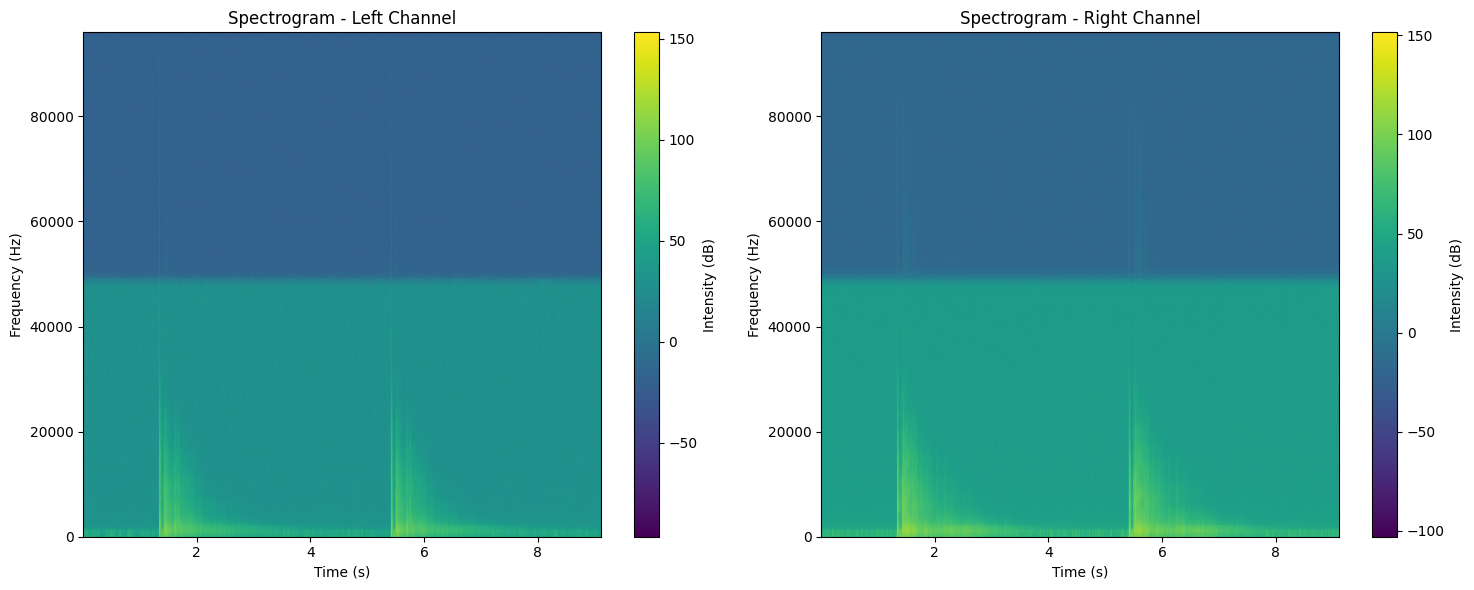

In [13]:
# Plotting side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plotting for the left channel
img_left = axes[0].specgram(leftChannel, Fs=sample_rate, cmap='viridis', aspect='auto')[3]
axes[0].set_title('Spectrogram - Left Channel')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Frequency (Hz)')
plt.colorbar(img_left, ax=axes[0], label='Intensity (dB)')

# Plotting for the right channel
img_right = axes[1].specgram(rightChannel, Fs=sample_rate, cmap='viridis', aspect='auto')[3]
axes[1].set_title('Spectrogram - Right Channel')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Frequency (Hz)')
plt.colorbar(img_right, ax=axes[1], label='Intensity (dB)')

plt.tight_layout()  # Ensures proper spacing between subplots

----
# UrbanSound8K

In [14]:
pathToUrbanIndex = "./UrbanSound8K/metadata/UrbanSound8K.csv"
urbanOGIndex = pd.read_csv(pathToUrbanIndex)
print(urbanOGIndex[:5])

      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  


In [15]:
print("Length stats")
print(f"Max: {urbanOGIndex['end'].max(axis=0)}")
print(f"Min: {urbanOGIndex['end'].min(axis=0)}")
print(f"Mean: {urbanOGIndex['end'].mean(axis=0)}")
print(f"Mode: {urbanOGIndex['end'].mode()}")
print(f"Median: {urbanOGIndex['end'].median(axis=0)}")

Length stats
Max: 604.125356
Min: 0.105962
Mean: 42.25331229638113
Mode: 0    4.0
Name: end, dtype: float64
Median: 14.0


In [16]:
print(f"number of gunshot audio files before removal {len(urbanOGIndex[urbanOGIndex['class'].str.contains("gun")])}")

number of gunshot audio files before removal 374


In [17]:
# remove gunshots from sounds
urbanIndex = urbanOGIndex.drop(urbanOGIndex[urbanOGIndex['class'].str.contains("gun")].index)
print(f"number of gunshot audio files after removal {len(urbanIndex[urbanIndex['class'].str.contains("gun")])}")
urbanIndex = urbanIndex.rename(columns={"slice_file_name": "Filename"})
urbanIndex

number of gunshot audio files after removal 0


,Filename,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


In [18]:
urbanIndex = urbanIndex.drop(['fsID', 'salience'], axis=1)

In [19]:
# "duration_secs"
startTimes = list(urbanIndex["start"])
endTimes = list(urbanIndex["end"])
durations = [endTimes[i]-startTimes[i] for i in range(len(startTimes))]
urbanIndex["duration_secs"] = durations
urbanIndex

,Filename,start,end,fold,classID,class,duration_secs
0,100032-3-0-0.wav,0.000000,0.317551,5,3,dog_bark,0.317551
1,100263-2-0-117.wav,58.500000,62.500000,5,2,children_playing,4.000000
2,100263-2-0-121.wav,60.500000,64.500000,5,2,children_playing,4.000000
3,100263-2-0-126.wav,63.000000,67.000000,5,2,children_playing,4.000000
4,100263-2-0-137.wav,68.500000,72.500000,5,2,children_playing,4.000000
...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,159.522205,163.522205,7,1,car_horn,4.000000
8728,99812-1-3-0.wav,181.142431,183.284976,7,1,car_horn,2.142545
8729,99812-1-4-0.wav,242.691902,246.197885,7,1,car_horn,3.505983
8730,99812-1-5-0.wav,253.209850,255.741948,7,1,car_horn,2.532098


In [20]:
urbanIndex = urbanIndex.drop(['start', 'end'], axis=1)
urbanIndex

,Filename,fold,classID,class,duration_secs
0,100032-3-0-0.wav,5,3,dog_bark,0.317551
1,100263-2-0-117.wav,5,2,children_playing,4.000000
2,100263-2-0-121.wav,5,2,children_playing,4.000000
3,100263-2-0-126.wav,5,2,children_playing,4.000000
4,100263-2-0-137.wav,5,2,children_playing,4.000000
...,...,...,...,...,...
8727,99812-1-2-0.wav,7,1,car_horn,4.000000
8728,99812-1-3-0.wav,7,1,car_horn,2.142545
8729,99812-1-4-0.wav,7,1,car_horn,3.505983
8730,99812-1-5-0.wav,7,1,car_horn,2.532098


In [34]:
# urbanIndex.to_csv("urbanIndex", index=False)
paths = list(urbanIndex['Filename'])
folds = list(urbanIndex['fold'])
backgroundSoundFiles = [[f"./UrbanSound8K/audio/fold{folds[i]}/{paths[i]}"] for i in range(0, len(paths))]
backgroundSoundFiles

[['./UrbanSound8K/audio/fold5/100032-3-0-0.wav'],
 ['./UrbanSound8K/audio/fold5/100263-2-0-117.wav'],
 ['./UrbanSound8K/audio/fold5/100263-2-0-121.wav'],
 ['./UrbanSound8K/audio/fold5/100263-2-0-126.wav'],
 ['./UrbanSound8K/audio/fold5/100263-2-0-137.wav'],
 ['./UrbanSound8K/audio/fold5/100263-2-0-143.wav'],
 ['./UrbanSound8K/audio/fold5/100263-2-0-161.wav'],
 ['./UrbanSound8K/audio/fold5/100263-2-0-3.wav'],
 ['./UrbanSound8K/audio/fold5/100263-2-0-36.wav'],
 ['./UrbanSound8K/audio/fold10/100648-1-0-0.wav'],
 ['./UrbanSound8K/audio/fold10/100648-1-1-0.wav'],
 ['./UrbanSound8K/audio/fold10/100648-1-2-0.wav'],
 ['./UrbanSound8K/audio/fold10/100648-1-3-0.wav'],
 ['./UrbanSound8K/audio/fold10/100648-1-4-0.wav'],
 ['./UrbanSound8K/audio/fold2/100652-3-0-0.wav'],
 ['./UrbanSound8K/audio/fold2/100652-3-0-1.wav'],
 ['./UrbanSound8K/audio/fold2/100652-3-0-2.wav'],
 ['./UrbanSound8K/audio/fold2/100652-3-0-3.wav'],
 ['./UrbanSound8K/audio/fold10/100795-3-0-0.wav'],
 ['./UrbanSound8K/audio/fold10/

In [35]:
file = open('urbanIndex.csv', 'w+', newline ='')
with file:    
    write = csv.writer(file)
    write.writerows(backgroundSoundFiles)

In [22]:
print(urbanIndex.iloc[0]["Filename"])
filename = f"./UrbanSound8K/audio/fold{urbanIndex.iloc[0]["fold"]}/" + urbanIndex.iloc[0]["Filename"]
print(f"opening file {filename}")
sample_rate, samples = wavfile.read(filename) # this is stereo (left and righgt speakers) so we will have to split it
leftChannel = samples[:,0]
rightChannel = samples[:,1]
leftFrequencies, leftTime, leftSpectrogram = signal.spectrogram(leftChannel, sample_rate)
rightFrequencies, rightTime, rightSpectrogram = signal.spectrogram(rightChannel, sample_rate)

100032-3-0-0.wav
opening file ./UrbanSound8K/audio/fold5/100032-3-0-0.wav


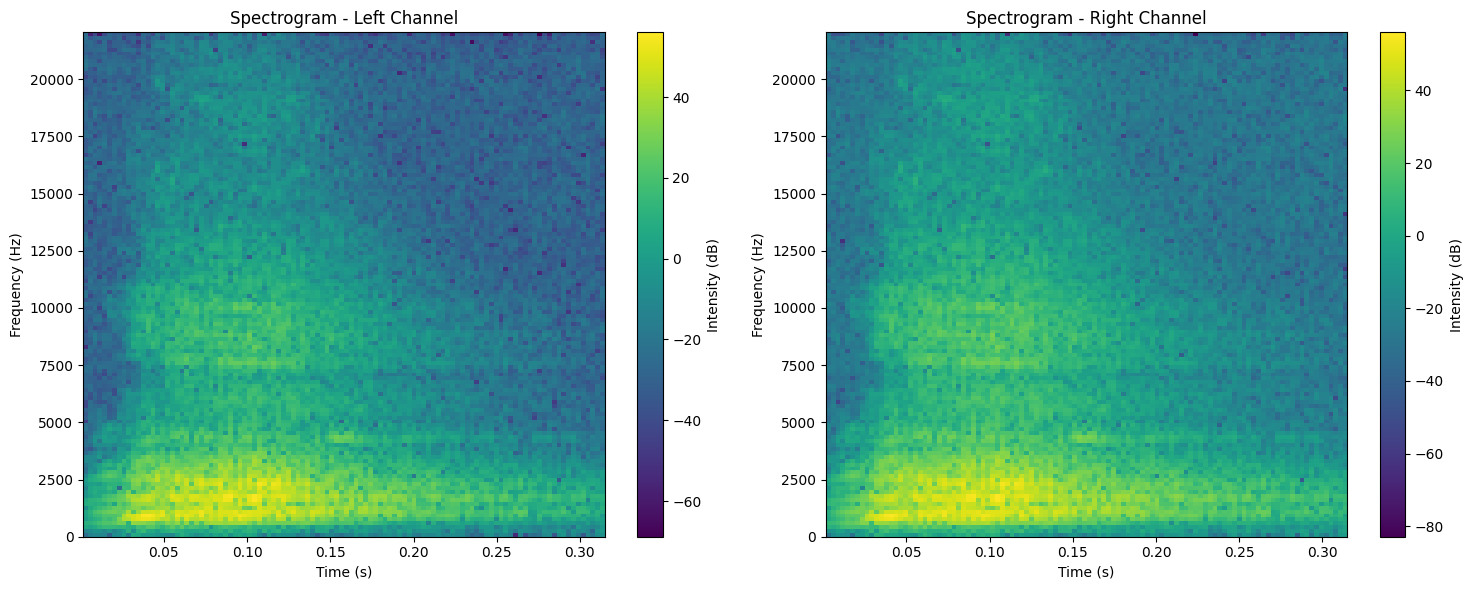

In [23]:
# Plotting side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plotting for the left channel
img_left = axes[0].specgram(leftChannel, Fs=sample_rate, cmap='viridis', aspect='auto')[3]
axes[0].set_title('Spectrogram - Left Channel')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Frequency (Hz)')
plt.colorbar(img_left, ax=axes[0], label='Intensity (dB)')

# Plotting for the right channel
img_right = axes[1].specgram(rightChannel, Fs=sample_rate, cmap='viridis', aspect='auto')[3]
axes[1].set_title('Spectrogram - Right Channel')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Frequency (Hz)')
plt.colorbar(img_right, ax=axes[1], label='Intensity (dB)')

plt.tight_layout()  # Ensures proper spacing between subplots

In [24]:
print("Background nosie stats")
print(f"Size {len(urbanIndex)}")
print(f"Max: {urbanIndex['duration_secs'].max(axis=0)}")
print(f"Min: {urbanIndex['duration_secs'].min(axis=0)}")
print(f"Mean: {urbanIndex['duration_secs'].mean(axis=0)}")
print(f"Mode: {urbanIndex['duration_secs'].mode()}")
print(f"Median: {urbanIndex['duration_secs'].median(axis=0)}")

Background nosie stats
Size 8358
Max: 4.000000000000028
Min: 0.05451700000000015
Mean: 3.695551448193348
Mode: 0    4.0
Name: duration_secs, dtype: float64
Median: 4.0


In [25]:
print("Gunshots stats")
print(f"Size {len(filteredGunshotIndex)}")
print(f"Max: {filteredGunshotIndex['duration_secs'].max(axis=0)}")
print(f"Min: {filteredGunshotIndex['duration_secs'].min(axis=0)}")
print(f"Mean: {filteredGunshotIndex['duration_secs'].mean(axis=0)}")
print(f"Mode: {filteredGunshotIndex['duration_secs'].mode()}")
print(f"Median: {filteredGunshotIndex['duration_secs'].median(axis=0)}")

Gunshots stats
Size 284
Max: 56.417520833333334
Min: 1.6525520833333334
Mean: 13.32723837294601
Mode: 0    6.741333
1    9.699813
Name: duration_secs, dtype: float64
Median: 11.024125


----
# combining background to make norm 60sec clips 
Notice thw following warrning from the previous authors 

* <b>Avoid reshuffling</b>, as it can lead to inaccuracies by incorrectly distributing related samples. Stick to the provided folds for training and testing. 
* <b>Opt for 10-fold cross-validation</b> over 5-fold and report the average score for a more robust evaluation. This ensures comparability with existing literature results.

see <i>Before You Download: Avoid Common Pitfalls!</i> <a href="https://urbansounddataset.weebly.com/urbansound8k.html">here<a>


In [26]:
# example of combining audio files
sound1 = AudioSegment.from_file("./UrbanSound8K/audio/fold5/100032-3-0-0.wav", format="wav")
sound2 = AudioSegment.from_file("./gunshots/freefirearmsfx/MasterTracks/A_33.wav", format="wav")

# sound1 6 dB louder
louder = sound2 + 60

# Overlay sound2 over sound1 at position 0  (use louder instead of sound1 to use the louder version)
overlay = louder.overlay(sound1, position=0)


# simple export
file_handle = overlay.export("output.mp3", format="mp3")

In [27]:
urbanIndex.columns

Index(['Filename', 'fold', 'classID', 'class', 'duration_secs'], dtype='object')

In [28]:
# backgoundSounds = [(path,dur) for path, urbanIndex['duration_secs'] in ]
paths = list(urbanIndex['Filename'])
durations = list(urbanIndex['duration_secs'])
folds = list(urbanIndex['fold'])
backgoundBits = [(f"./UrbanSound8K/audio/fold{folds[i]}/{paths[i]}", durations[i]) for i in range(0, len(paths))]
backgoundBits

[('./UrbanSound8K/audio/fold5/100032-3-0-0.wav', 0.317551),
 ('./UrbanSound8K/audio/fold5/100263-2-0-117.wav', 4.0),
 ('./UrbanSound8K/audio/fold5/100263-2-0-121.wav', 4.0),
 ('./UrbanSound8K/audio/fold5/100263-2-0-126.wav', 4.0),
 ('./UrbanSound8K/audio/fold5/100263-2-0-137.wav', 4.0),
 ('./UrbanSound8K/audio/fold5/100263-2-0-143.wav', 4.0),
 ('./UrbanSound8K/audio/fold5/100263-2-0-161.wav', 4.0),
 ('./UrbanSound8K/audio/fold5/100263-2-0-3.wav', 4.0),
 ('./UrbanSound8K/audio/fold5/100263-2-0-36.wav', 4.0),
 ('./UrbanSound8K/audio/fold10/100648-1-0-0.wav', 0.6485250000000002),
 ('./UrbanSound8K/audio/fold10/100648-1-1-0.wav', 1.0538530000000002),
 ('./UrbanSound8K/audio/fold10/100648-1-2-0.wav', 0.4053280000000008),
 ('./UrbanSound8K/audio/fold10/100648-1-3-0.wav', 1.6213109999999986),
 ('./UrbanSound8K/audio/fold10/100648-1-4-0.wav', 1.8645080000000007),
 ('./UrbanSound8K/audio/fold2/100652-3-0-0.wav', 4.0),
 ('./UrbanSound8K/audio/fold2/100652-3-0-1.wav', 4.0),
 ('./UrbanSound8K/audi

In [29]:
AudioSegment.empty().duration_seconds

0.0

In [30]:
def makeBackgroundAudio(audioBits):
    BackgroundAudio = AudioSegment.empty()
    samples = random.sample(audioBits, 1200) # shortest clip is 0.05secs so a sample of 1200 guarantees at least 60secs of audio
    while BackgroundAudio.duration_seconds < 60:
        path = samples[0][0]
        randomBit = AudioSegment.from_file(path, format="wav", codec="pcm_s32le")
        BackgroundAudio = BackgroundAudio + randomBit
        samples = samples[1:]
    BackgroundAudio = BackgroundAudio[:60 * 1000] # convert milliseconds to seconds
    return BackgroundAudio

In [31]:
makeBackgroundAudio(backgoundBits)

In [32]:
for i in range(10):
    makeBackgroundAudio(backgoundBits).export(f"./backgound/background{i}.wav", format="wav", codec="pcm_s32le")